In [2]:
import fastbook
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [3]:
import os
import pandas as pd
import numpy as np

cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

realestate = pd.read_csv("./Ames Real Estate Data.csv", low_memory = False)
HousePrice = pd.read_csv("./Ames_HousePrice.csv")

Current working directory: /home/koz/koz/NYCDSA/AmesWorking


In [4]:
realestate.shape

(22213, 91)

In [5]:
HousePrice.shape

(2580, 82)

In [7]:
HousePrice[:4]

,Unnamed: 0,PID,GrLivArea,SalePrice,...,MoSold,YrSold,SaleType,SaleCondition
0,1,909176150,856,126000,...,3,2010,WD,Normal
1,2,905476230,1049,139500,...,2,2009,WD,Normal
2,3,911128020,1001,124900,...,11,2007,WD,Normal
3,4,535377150,1039,114000,...,5,2009,WD,Normal


In [39]:
dep_var = 'SalePrice'
HousePrice[dep_var] = np.log(HousePrice[dep_var])

In [9]:
HousePrice[:4]["MSSubClass"]

0     30
1    120
2     30
3     70
Name: MSSubClass, dtype: int64

In [40]:
numeric_columns = HousePrice._get_numeric_data().columns
numeric_columns

Index(['Unnamed: 0', 'PID', 'GrLivArea', 'SalePrice', 'MSSubClass',
       'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [41]:
numeric_df = HousePrice[list(set(numeric_columns) - set(['PID', 'Unnamed: 0',"MSSubClass"]))]

In [42]:
numeric_df.shape

(2580, 36)

In [36]:
missingRows = HousePrice.isnull().any(axis = 1)
missingCols = HousePrice.isnull().any(axis = 0)
HousePrice.columns[missingCols]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical',
       'BsmtFullBath', 'BsmtHalfBath', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

Text(0.5, 1.0, 'Proportion of Missing Values')

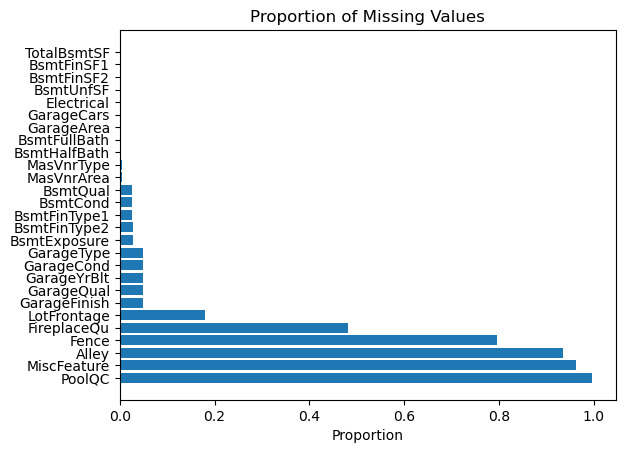

In [67]:
#count NA
prop_miss = HousePrice.isna().mean().sort_values(ascending = False)
prop_miss = prop_miss[prop_miss>0].reset_index()
prop_miss.columns = ["Variable","Proportion missing" ]
plt.rcdefaults()
fig,ax = plt.subplots()

ax.barh(prop_miss["Variable"], prop_miss["Proportion missing"])
ax.set_xlabel("Proportion")
ax.set_title("Proportion of Missing Values")

In [69]:
HousePrice = HousePrice.drop(['PoolQC', 'MiscFeature','Alley','Fence'], axis = 1)

In [72]:
def cat_miss(var, value): 
    mis_var = HousePrice[var].isna()
    HousePrice.loc[mis_var,var]= value
cat_miss('Electrical', 'SBrkr')  #impute Electrical missing with the most frequent value
cat_miss('MasVnrType', 'None')
cat_miss('FireplaceQu','No Fireplace')

def num_miss(var, value): 
    HousePrice[var] = HousePrice[var].fillna(value)
    return 
    
num_miss('BsmtFullBath', 0)
num_miss('BsmtHalfBath', 0)
num_miss('GarageCars', 2)
num_miss('GarageArea', \
         HousePrice[HousePrice['GarageCars']==2].mean()['GarageArea'])
num_miss('MasVnrArea',0)

In [73]:
gr_var = ['GarageFinish', 'GarageQual', 'GarageYrBlt','GarageCond', 'GarageType']
HousePrice[gr_var] = HousePrice[gr_var].fillna('No Garage')
bsm_var = ['BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtCond','BsmtQual']
HousePrice[bsm_var] = HousePrice[bsm_var].fillna('No Basement')
num_bsmt = ['BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF']
HousePrice[num_bsmt] = HousePrice[num_bsmt].fillna(0)
# Impute LotFrontage using the type of dwelling in the sell

HousePrice1 = HousePrice[['MSSubClass','LotFrontage']]

# LF_dict = HousePrice1.groupby('MSSubClass').mean().to_dict()
# rowmissing = HousePrice1.LotFrontage.isnull()
# HousePrice1.loc[rowmissing,'LotFrontage']= \
#    HousePrice1[rowmissing].apply(lambda x: LF_dict['LotFrontage'][x[0]], axis = 1)
# # one LotFrontage is missing because of missing group mean(only one value). 
# # Because the total LotArea in this observation is quite small, I will use the the smallest group mean to impute
# test = HousePrice1['LotFrontage'].isnull()
# HousePrice1 = HousePrice1.fillna(HousePrice1.groupby('MSSubClass').mean().min())
# HousePrice[['MSSubClass','LotFrontage']] = HousePrice1

# HousePrice.info()

In [75]:
test_cond = HousePrice['YrSold'] == 2010
remainder_cond = HousePrice['YrSold'] < 2010
HousePrice_test = HousePrice[test_cond]
HousePrice_test.shape
HousePrice_train_and_valid = HousePrice[remainder_cond]
HousePrice_train_and_valid.shape

(2265, 78)

In [76]:
valid_cond = HousePrice_train_and_valid['YrSold'] == 2009
train_idx = np.where(~valid_cond)[0]
valid_idx = np.where(valid_cond)[0]

splits = (list(train_idx), list(valid_idx))

In [77]:
procs = [ Categorify, FillMissing ]

In [86]:
cont, cat = cont_cat_split(HousePrice_train_and_valid, 1, dep_var=dep_var)
# print(cont, cat)
# import pdb; pdb.set_trace()
tpo = TabularPandas(HousePrice_train_and_valid, procs, cont, cat, y_names=dep_var, splits=splits)
len(tpo.train), len(tpo.valid)

(1680, 585)

In [79]:
def root_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def model_rmse(m, xs, y): return root_mse( m.predict(xs), y)

In [87]:
xs, y = tpo.train.xs, tpo.train.y
valid_xs, valid_y = tpo.valid.xs, tpo.valid.y

In [88]:
m = DecisionTreeRegressor()
m.fit(xs, y)

ValueError: could not convert string to float: 'C (all)'

In [82]:
model_rmse(m, xs, y), m.get_n_leaves()

(0.001154, 1613)

In [83]:
model_rmse(m, valid_xs, valid_y)

0.333629

In [85]:
m2 = DecisionTreeRegressor(min_samples_leaf = 25)
m2.fit(xs, y)
model_rmse(m2, xs, y), model_rmse(m2, valid_xs, valid_y), m2.get_n_leaves()

(0.14506, 0.27844, 51)

In [33]:
def rf(xs, y, n_estimators=400, max_samples=200,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [60]:
m3 = rf(xs, y);

In [61]:
model_rmse(m3, xs, y)

0.134856

In [62]:
model_rmse(m3, valid_xs, valid_y)

0.263626